In [8]:
import os
from pathlib import Path
import re
import logging
from ast import literal_eval

import pydot
import os
from IPython.display import Image, display
from datetime import datetime

In [9]:
import re

text = """Line 1: This line does not match;
Line 2: This line does not match the specified text and ends with a semicolon;
Line 3: This line also matches the specified text and ends with a semicolon;
Line 4: This line matches the specified text but does not end with a semicolon"""

pattern = r'^(?:.*\r?\n)*.*specified text(?:[\s\S](?!;\s*$))*?;(?!\S)'

matches = re.findall(pattern, text, re.MULTILINE)

for match in matches:
    print(match)


In [10]:
datetime.now().time().strftime('%m.%d.%Y %H.%M.%S')

'01.01.1900 20.22.49'

In [11]:
t = datetime.now().time().strftime('%m.%d.%Y %H.%M.%S')
file_log = logging.FileHandler(f'ModelGraph {t}.log', encoding='utf-8')
console_out = logging.StreamHandler()

logging.basicConfig(
    handlers=(file_log, console_out), 
    level=logging.INFO,
    format='[%(asctime)s | %(levelname)s]: %(message)s', 
    datefmt='%d.%m.%Y %H:%M:%S',
    )


In [12]:
import re

text = "['USD','Total Cost','VAT on opex deliveries','Value']=>DB('Tax',!Version,!Year,!Month,!Entity,ATTRS('Entity', !Entity, 'Currency'),'VAT on OpEx','Volume');\n['Bissa-Bouly','USD','Total Cost','VAT on opex deliveries','Value']=>DB('Tax',!Version,!Year,!Month,'Bissa',ATTRS('Entity', 'Bissa', 'Currency'),'VAT on OpEx','Volume');\n['USD','Payments','Value']=>DB('CF_Payments',!Version,!Year,!Month,ATTRS('Entity',!Entity,'Other_CF_Payments_Feeder'),!Currency,'Value',ELPAR('WC_Material_and_Service',!WC_Material_and_Service, 1),'Volume')"

feeders_patern = r"^(?!#).*?=>\s*DB\(\s*'([^']+)"

names = re.findall(feeders_patern, text, flags=re.M)
print(names)

['Tax', 'Tax', 'CF_Payments']


In [17]:
directory = Path("C:\\ProjectsPy\\IMB_ModelGraph\\NG Rules")

#pattern_rule = re.compile(".*?=[^>]*?DB\(\s*\'([^\']*?)\'")
pattern_rule = re.compile("[^>\s]\s*DB\(\s*\'([^\']*?)\'")
pattern_comment = re.compile('(?sm)(^#[^\r\n]*|"""(.*?)""")')
pattern_vSourseCube = re.compile("vSourceCube\s*=\s*'(.*)'")
pattern_proc_name = re.compile('602,"(.*)"')
pattern_cellgetput = re.compile('Cell(Put|Get|Increment)(N|S)\(([^,]*),([^,]*)')

pattern_full_db_rule = re.compile(".*?=[^>]*?DB\((.*?)\)", re.DOTALL)
#(\[[^=;]*?\])\s*?=\s*?N[^;]*?DB\(\s*'([^\']*?)'
if directory.exists():
    logging.info(f'Start of graph creation')
    logging.info(f'Working directory {directory}')
else:
    logging.error(f'{directory} path not found')
    raise FileNotFoundError()

[14.06.2023 20:23:45 | INFO]: Start of graph creation
[14.06.2023 20:23:45 | INFO]: Working directory C:\ProjectsPy\IMB_ModelGraph\NG Rules


In [18]:
def del_comment(doc):
    matches = re.findall(pattern_comment, doc)
    for match in matches:
        doc = doc.replace(match[0], '')
    return doc

In [19]:
class IncomeMeasure():
    def __init__(self, sourse, target, measures=[]):
        self.sourse = sourse
        self.target = target
        self.measures = measures
    
    def add_measure(self, measure):
        self.measures.append(measure)

    def get_values(self):
        return((self.sourse, self.target, self.measures))

    def __str__(self):
        return f"{self.sourse} -> {self.target} {self.measures}"

In [20]:
dependency = []
cube_list = []
empty_rux = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    #if filename == 'WC_Report.RUX':     
    if filename.endswith('.RUX') and not filename.startswith('}'):
        cube_list.append(filename)
        
        #читаем весь документ
        textfile = open(f, 'r', encoding='UTF-8')
        filetext = textfile.read()
        textfile.close()

        all_db = []
        matches = re.findall(feeders_patern, filetext, flags=re.M)
        for match in matches:
            if match != filename[:-4] and (filename[:-4], match) not in all_db:
                all_db.append((filename[:-4], match))
        #print(all_db)
        if all_db != []:
            dependency.append(all_db)
        else:
            empty_rux.append(filename)


In [21]:
empty_rux

['ADM_BATCH_Source_Settings.RUX',
 'ADM_BP_Load_Log.RUX',
 'ADM_CopyVersionData_Settings.RUX',
 'ADM_Currency.RUX',
 'ADM_Current_BATCH_Source.RUX',
 'ADM_Date.RUX',
 'ADM_Dividends.RUX',
 'ADM_KPI_Compare.RUX',
 'ADM_KPI_TCC_Report_Drivers_Picklist.RUX',
 'ADM_LIBOR 3M.RUX',
 'ADM_LIBOR.RUX',
 'ADM_Plan_Year.RUX',
 'ADM_Security.RUX',
 'ADM_Variation.RUX',
 'ADM_Version_Access.RUX',
 'ADM_Version_Control.RUX',
 'BS_Lines_MapFact.RUX',
 'CAPEX_Bridge.RUX',
 'CAPEX_Bridge_FCBP.RUX',
 'CAPEX_Project_list_Attr.RUX',
 'CAPEX_Project_list_Attr2.RUX',
 'CAPEX_Project_list_Other_Actual_Mapping.RUX',
 'CF_Lines_MapFact.RUX',
 'CF_Payments.RUX',
 'CF_Payments_DrillHana.RUX',
 'COMMENTS.RUX',
 'CopyCubeSettings.RUX',
 'CostElement_MapForFact.RUX',
 'EBITDA_Bridge_Factors.RUX',
 'EBITDA_Bridge_Factors_FCBP w Infl.RUX',
 'EBITDA_Bridge_Factors_FCBP.RUX',
 'Entity_MapForFact.RUX',
 'FixedCostsMapping.RUX',
 'KPI_AISC_Bridge.RUX',
 'KPI_AISC_Bridge_.RUX',
 'KPI_AISC_Bridge_Factors.RUX',
 'KPI_AISC_B

In [27]:
with open("C:/ProjectsPy/IMB_ModelGraph/Empty_rux.txt", "w") as f:
    for s in empty_rux:
        f.write(f'{s}\n')

In [22]:
dependency

[[('ADM_KPI_Report_fed', 'KPI_Report')],
 [('ADM_KPI_TCC_Report_fed', 'KPI_TCC_Report')],
 [('ADM_Tax', 'WC_Base'), ('ADM_Tax', 'Tax')],
 [('ADM_Version', 'WC_Material_and_Service')],
 [('BS', 'CF'), ('BS', 'KPI_Report'), ('BS', 'WC_Dashboard')],
 [('CAPEX', 'KPI_Report'), ('CAPEX', 'BS'), ('CAPEX', 'Tax')],
 [('CAPEX_by_Pit_Drivers', 'KPI_Report_by_Pit')],
 [('CAPEX_Project_list', 'Capex_project_list_transform_to_dimension'),
  ('CAPEX_Project_list', 'CAPEX_by_Pit_Drivers')],
 [('CAPEX_Project_list_Fact', 'CAPEX'),
  ('CAPEX_Project_list_Fact', 'KPI_Report'),
  ('CAPEX_Project_list_Fact', 'CAPEX_Project_list')],
 [('Capex_project_list_transform_to_dimension', 'CAPEX')],
 [('CF', 'CF_Report'),
  ('CF', 'KPI_Report'),
  ('CF', 'WC_Report_CF'),
  ('CF', 'WC_Report_forCheck')],
 [('CF_Report', 'KPI_Report'), ('CF_Report', 'BS')],
 [('EBITDA_Bridge', 'KPI_Report')],
 [('HR_Report_TCC', 'KPI_TCC_Report'),
  ('HR_Report_TCC', 'KPI_GA_Report'),
  ('HR_Report_TCC', 'KPI_Cost_Center_Alloc'),
  

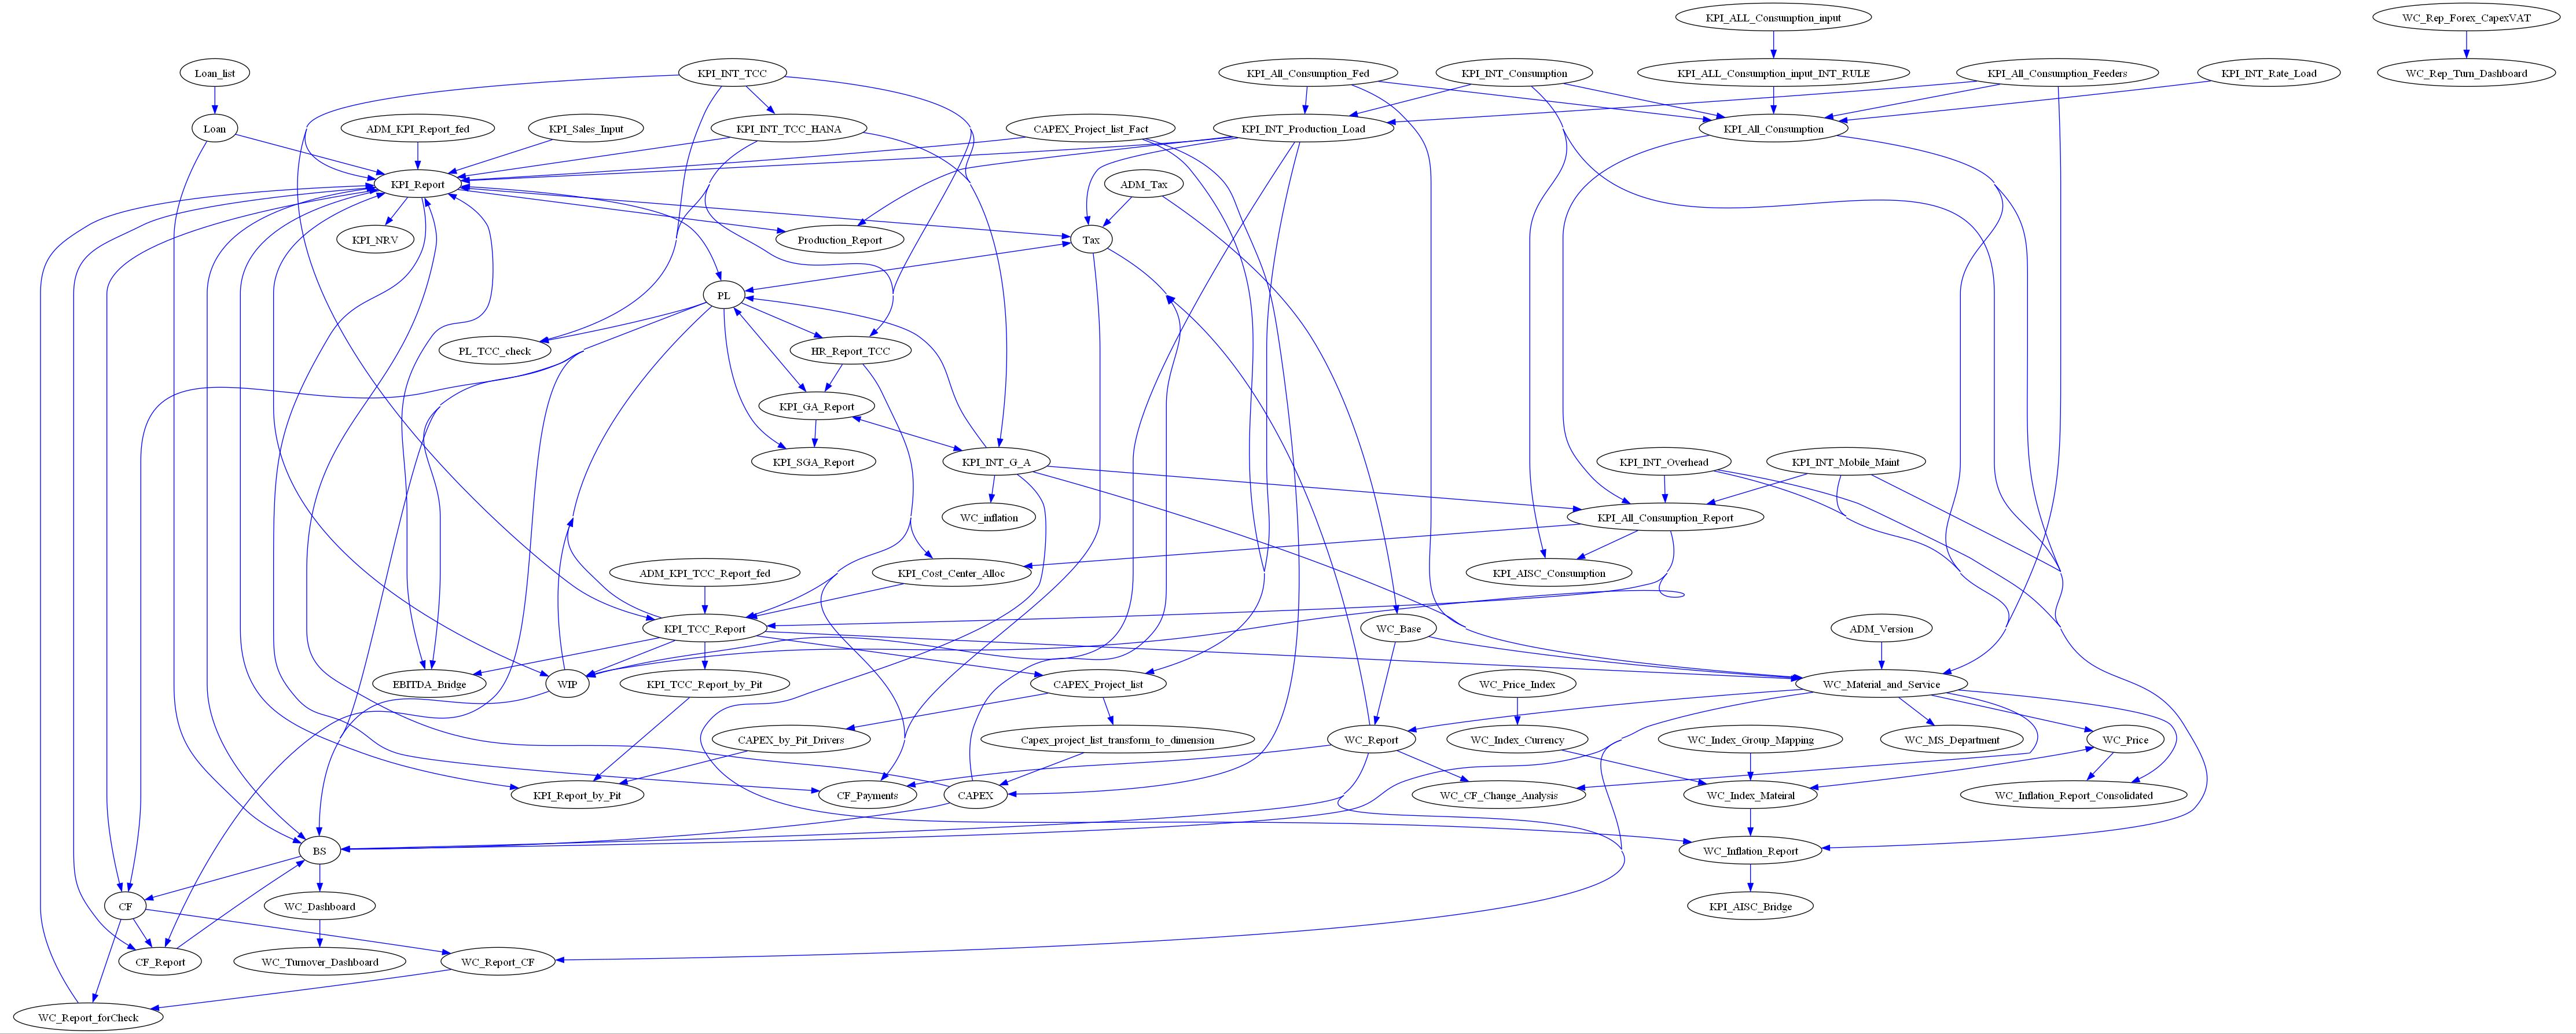

In [23]:
#Create a graph object of directed type
G = pydot.Dot(graph_type = "digraph",strict=True, concentrate=True, tooltip='')
G.set_rankdir('TB')
#G.set_overlap('prism')
#G.set_overlap('orthoyx')
#G.set_overlap_scaling('-0.4')
G.set_ratio('0.4')
#G.set_edge_defaults("'decorate'=True")
#G.set_size('"5,8!"')
#G.set_ratio("fill")
# for cube in cube_list:
#     node = pydot.Node(cube, color="blue")
#     G.add_node(node)

for cube in dependency:
    for sourse, target in cube:
        edge = pydot.Edge(sourse, target, color="blue", decorate='true')
        G.add_edge(edge)
    
# for sourse, target in res_proc:
#     edge = pydot.Edge(sourse, target, color="red", label='subclass', decorate='true')
#     G.add_edge(edge)

# for proc in proc_list:
#     node = pydot.Node(proc, color="red", shape='parallelogram')
#     G.add_node(node)

dt_string = datetime.now().strftime("%d%m%Y_%H%M%S")

im = Image(G.create_jpeg(encoding='utf-8'))

#Display the image
display(im)

#Save the image in jpeg format

#G.write_gif(f"output/ModelGraph_{dt_string}.gif", encoding='utf-8')
G.write_svg(f"output/ModelGraph_{dt_string}.svg", encoding='utf-8')

In [32]:
filetext

'\ufeffFORMAT==100\n#Region System\nFEEDSTRINGS;\nSKIPCHECK;\n##########################\n# Dev.:\t\tdarm@columbusglobal.com\n# Date:\t\t26.06.2019\n# v.1\n##########################\n\n[\'Taparko\'] = if (NUMBR(!Year)>=2023,Stet,Continue);\n[\'Taparko\'] =S: if (NUMBR(!Year)>=2023,Stet,Continue);\n\n\n### Consolidate\n\n[\'Nordgold\']=C:ConsolidateChildren(\'Entity\')+[\'Berezitovy\'];\n\n\n###########################2021 PLAnned########################################\n[\'2021\',\'BP_2020\',\'Value_YTD\', \'01\'] =N: [\'Value\'];\n\n[\'2021\',\'BP_2020\',{\'Advances opening balance (incl. VAT)\',\'Accounts payable opening balance (incl. VAT)\'},\'Value_YTD\']=N:DB(\'WC_Report\',!Version,DB(\'ADM_Date\',!Year,!Month,\'-1\',\'Year\'),DB(\'ADM_Date\',!Year,!Month,\'-1\',\'Month\'),!Entity,!Currency,!WC_Material_and_Service,!Item_WC_Report,\'Value_YTD\');\n\n[\'2021\',\'BP_2020\',{\'Advances closing balance (incl. VAT)\',\'Accounts payable closing balance (incl. VAT)\'},\'Value_YTD\']=N:

In [50]:
res_rule = []
temp_res_rule= []
cube_list = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if filename == '0114_ПРДЖ_Емкость_Рынка_Бетон_по_Потребл_Щебень_Цемент.RUX':     
        if filename.endswith('.RUX') and not filename.startswith('}'):
            cube_list.append(filename)
            
            #читаем весь документ
            textfile = open(f, 'r', encoding='UTF-8')
            filetext = textfile.read()
            textfile.close()

            #Ищем и удаляем закоменченные
            filetext = del_comment(filetext)

            #Приходящий элемент
            #Ищем текст полного DB 
            all_db = []
            matches = re.findall(pattern_full_db_rule, filetext)
            for match in matches:
                match = match.replace('\n', '')
                match = match.split(',')
                clear_match = []
                for m in match:
                    try:
                        clear_match.append(literal_eval(m).lstrip())
                    except:
                        clear_match.append(m.lstrip())
                all_db.append(clear_match)
            print(all_db)

            #Ищем вхождения [] = DB('')
            matches = re.findall(pattern_rule, filetext)
            for match in matches:
                if (match, filename[:-4]) not in temp_res_rule:
                    temp_res_rule.append((match, filename[:-4]))
                    res_rule.append(IncomeMeasure(match, filename[:-4]))
                    print(res_rule[-1].get_values())
            
            for db in all_db:
                
            
#logging.info(f'Found {len(res_rule)} edges for {len(cube_list)} cubes')

[['0157_ПРДЖ_План_Продаж_Результат_Отчет', '!Сценарий', '!Версия', '!Год', '!Период', 'КР_Итого', '!Производители', 'ПРОД_Итого', 'ПРД_04', 'УПАК_Итого', 'РЕГ_Итого', 'МО_Итого', 'ПОСТ_Итого', 'ПН_Итого', 'ТТ_Итого', '!Сегменты_рынка', 'ПРК_0000', 'КФ_Итого', 'ЦГ_Итого', 'ПКЗ_03_12_0012'], ['0113_ПРДЖ_Коэф_Пересчета_Бетона', '!Сценарий', '!Версия', '!Год', '!Период', '!Производители', 'РЕГ_Итого', 'ПКЗ_03_05_0026'], ['0157_ПРДЖ_План_Продаж_Результат_Отчет', '!Сценарий', '!Версия', '!Год', '!Период', 'КР_Итого', '!Производители', 'ПРОД_Итого', 'ПРД_01', 'УПАК_Итого', 'РЕГ_Итого', 'МО_Итого', 'ПОСТ_Итого', 'ПН_Итого', 'ТТ_Итого', '!Сегменты_рынка', 'ПРК_Итого', 'КФ_Итого', 'ЦГ_Итого', 'ПКЗ_03_12_0012'], ['0157_ПРДЖ_План_Продаж_Результат_Отчет', '!Сценарий', '!Версия', '!Год', '!Период', 'КР_Итого', '!Производители', 'ПРОД_Итого', 'ПРД_07', 'УПАК_Итого', 'РЕГ_Итого', 'МО_Итого', 'ПОСТ_Итого', 'ПН_Итого', 'ТТ_Итого', '!Сегменты_рынка', 'ПРК_Итого', 'КФ_Итого', 'ЦГ_Итого', 'ПКЗ_03_12_0012']

In [38]:
res_rule[0].get_values()

('0157_ПРДЖ_План_Продаж_Результат_Отчет',
 '0114_ПРДЖ_Емкость_Рынка_Бетон_по_Потребл_Щебень_Цемент',
 [])

### Ищем показатели в правилах

In [27]:
res_rule = []
cube_list = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if filename == '0114_ПРДЖ_Емкость_Рынка_Бетон_по_Потребл_Щебень_Цемент.RUX': 
        if filename.endswith('.RUX') and not filename.startswith('}'):
            #читаем весь документ
            textfile = open(f, 'r', encoding='UTF-8')
            filetext = textfile.read()
            textfile.close()

            #Ищем и удаляем закоменченные
            filetext = del_comment(filetext)

            #Приходящий элемент
            #Ищем текст полного DB 
            all_rules = []
            matches = re.findall(pattern_full_db_rule, filetext)
            for match in matches:
                match = match.replace('\n', '')
                match = match.split(',')
                clear_match = []
                for m in match:
                    try:
                        clear_match.append(literal_eval(m).lstrip())
                    except:
                        clear_match.append(m.lstrip())
                all_rules.append(clear_match)
                print(clear_match)
            
            for db in all_rules:
                if db[-1].startswith('!'):
                    pass
                else:
                    pass
            

#logging.info(f'Found {len(res_rule)} edges for {len(cube_list)} cubes')
print(f'Found {len(res_rule)} edges for {len(cube_list)} cubes')

['0157_ПРДЖ_План_Продаж_Результат_Отчет', '!Сценарий', '!Версия', '!Год', '!Период', 'КР_Итого', '!Производители', 'ПРОД_Итого', 'ПРД_04', 'УПАК_Итого', 'РЕГ_Итого', 'МО_Итого', 'ПОСТ_Итого', 'ПН_Итого', 'ТТ_Итого', '!Сегменты_рынка', 'ПРК_0000', 'КФ_Итого', 'ЦГ_Итого', 'ПКЗ_03_12_0012']
['0113_ПРДЖ_Коэф_Пересчета_Бетона', '!Сценарий', '!Версия', '!Год', '!Период', '!Производители', 'РЕГ_Итого', 'ПКЗ_03_05_0026']
['0157_ПРДЖ_План_Продаж_Результат_Отчет', '!Сценарий', '!Версия', '!Год', '!Период', 'КР_Итого', '!Производители', 'ПРОД_Итого', 'ПРД_01', 'УПАК_Итого', 'РЕГ_Итого', 'МО_Итого', 'ПОСТ_Итого', 'ПН_Итого', 'ТТ_Итого', '!Сегменты_рынка', 'ПРК_Итого', 'КФ_Итого', 'ЦГ_Итого', 'ПКЗ_03_12_0012']
['0157_ПРДЖ_План_Продаж_Результат_Отчет', '!Сценарий', '!Версия', '!Год', '!Период', 'КР_Итого', '!Производители', 'ПРОД_Итого', 'ПРД_07', 'УПАК_Итого', 'РЕГ_Итого', 'МО_Итого', 'ПОСТ_Итого', 'ПН_Итого', 'ТТ_Итого', '!Сегменты_рынка', 'ПРК_Итого', 'КФ_Итого', 'ЦГ_Итого', 'ПКЗ_03_12_0012']
['0

In [9]:
res_proc = []
proc_list = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if filename.endswith('.pro') and filename[0].isdigit():
        proc_list.append(filename)
    
        #читаем весь документ
        textfile = open(f, 'r', encoding='UTF-8')
        filetext = textfile.read()
        textfile.close()

        #Ищем и удаляем закоменченные
        filetext = del_comment(filetext)

        #Находим имя процесса, vSourseName, CellPut и CellGet
        proc_name = re.findall(pattern_proc_name, filetext)[0]

        try:
            sourse_name = re.findall(pattern_vSourseCube, filetext)[0]
        except Exception as e:
            sourse_name = filename[:4]
            logging.warning(f'Не найден vSourseCube в процессе {filename}, для источника установленно имя {filename[:4]}')
        res_proc.append((sourse_name, filename))

        matches = list(set(re.findall(pattern_cellgetput, filetext)))
        for match in matches:
            if match[0] == 'Get':
                try:
                    node_name = literal_eval(match[2])
                except Exception as e:
                    node_name = match[2]
                if (node_name, filename) not in res_proc:
                    res_proc.append((node_name, filename))
            else:
                try:
                    node_name = literal_eval(match[3])
                except Exception as e:
                    node_name = match[3]
                if (filename, node_name) not in res_proc:
                    res_proc.append((filename, node_name))
        
logging.info(f'Found {len(res_proc)} edges for {len(proc_list)} processes')

[06.12.2022 12:15:58 | WARNING]: Не найден vSourseCube в процессе 0101_ПРДЖ_Использование_Упаковки_00.pro, для источника установленно имя 0101
[06.12.2022 12:15:58 | WARNING]: Не найден vSourseCube в процессе 01111_ПРДЖ_Тех.pro, для источника установленно имя 0111
[06.12.2022 12:15:58 | WARNING]: Не найден vSourseCube в процессе 0111_ПРДЖ_Сезонные_Коэффициенты.pro, для источника установленно имя 0111
[06.12.2022 12:15:58 | WARNING]: Не найден vSourseCube в процессе 0116_ПРДЖ_Внутригруп_Продажи_Цемент_Щебень_Утв.pro, для источника установленно имя 0116
[06.12.2022 12:15:58 | WARNING]: Не найден vSourseCube в процессе 0139_ПРДЖ_Первоначальный_ПП_Copy.pro, для источника установленно имя 0139
[06.12.2022 12:15:58 | WARNING]: Не найден vSourseCube в процессе 0139_ПРДЖ_Первоначальный_ПП_Copy_old.pro, для источника установленно имя 0139
[06.12.2022 12:15:58 | WARNING]: Не найден vSourseCube в процессе 0139_ПРДЖ_Первоначальный_ПП_Copy_v2.pro, для источника установленно имя 0139
[06.12.2022 12:

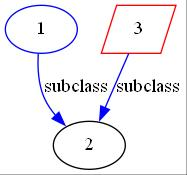

In [41]:
G = pydot.Dot(graph_type = "digraph")
G.set_charset('utf-8')

for sourse, target in [[1,2],[3,2]]:
    edge = pydot.Edge(sourse, target, color="blue", label='subclass')
    G.add_edge(edge)

node = pydot.Node('1', color="blue")
G.add_node(node)

node = pydot.Node('3', color="red", shape='parallelogram')
G.add_node(node)

im = Image(G.create_jpeg(encoding='utf-8'))

#Display the image
display(im)

In [52]:
#Create a graph object of directed type
G = pydot.Dot(graph_type = "digraph")
G.set_rankdir('TB')
G.set_overlap('prism')
G.set_overlap('scalexy')
G.set_overlap_scaling('-0.4')
G.set_ratio('0.4')
#G.set_edge_defaults("'decorate'=True")
#G.set_size('"5,8!"')
#G.set_ratio("fill")
# for cube in cube_list:
#     node = pydot.Node(cube, color="blue")
#     G.add_node(node)

for sourse, target in res_rule:
    edge = pydot.Edge(sourse, target, color="blue", label='subclass', decorate='true')
    G.add_edge(edge)
    
for sourse, target in res_proc:
    edge = pydot.Edge(sourse, target, color="red", label='subclass', decorate='true')
    G.add_edge(edge)

for proc in proc_list:
    node = pydot.Node(proc, color="red", shape='parallelogram')
    G.add_node(node)




dt_string = datetime.now().strftime("%d%m%Y_%H%M%S")

im = Image(G.create_jpeg(encoding='utf-8'))

#Display the image
display(im)

#Save the image in jpeg format

#G.write_gif(f"output/ModelGraph_{dt_string}.gif", encoding='utf-8')
G.write_svg(f"output/ModelGraph_{dt_string}.svg", encoding='utf-8')